# 📌 XGBOOST for Multi-step Sales Forecasting

In [1]:
# ===============================
# 📌 Step 1: Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

# ===============================
# 📌 Step 2: Load Dataset
# ===============================
df = pd.read_csv("Final dataset.csv")
df["Invoice Date"] = pd.to_datetime(df["Invoice Date"])
df = df.sort_values("Invoice Date")

# ===============================
# 📌 Step 3: Aggregate to Daily Sales
# ===============================
daily_sales = (
    df.groupby("Invoice Date")["Sales Amount"]
    .sum()
    .reset_index()
    .sort_values("Invoice Date")
)

# ===============================
# 📌 Step 4: Feature Engineering
# ===============================
daily_sales["Day"] = daily_sales["Invoice Date"].dt.day
daily_sales["Month"] = daily_sales["Invoice Date"].dt.month
daily_sales["Year"] = daily_sales["Invoice Date"].dt.year
daily_sales["DayOfWeek"] = daily_sales["Invoice Date"].dt.dayofweek
daily_sales["IsWeekend"] = (daily_sales["DayOfWeek"] >= 5).astype(int)
daily_sales["IsMonthStart"] = daily_sales["Invoice Date"].dt.is_month_start.astype(int)
daily_sales["IsMonthEnd"] = daily_sales["Invoice Date"].dt.is_month_end.astype(int)

# Lag features
for lag in [1, 2, 3, 7, 14, 30]:
    daily_sales[f"lag{lag}"] = daily_sales["Sales Amount"].shift(lag)

# Rolling mean & std
daily_sales["roll7_mean"] = daily_sales["Sales Amount"].shift(1).rolling(7).mean()
daily_sales["roll30_mean"] = daily_sales["Sales Amount"].shift(1).rolling(30).mean()
daily_sales["roll7_std"] = daily_sales["Sales Amount"].shift(1).rolling(7).std()
daily_sales["roll30_std"] = daily_sales["Sales Amount"].shift(1).rolling(30).std()

# Drop NA
daily_sales = daily_sales.dropna()

# ===============================
# 📌 Step 5: Train/Val/Test Split
# ===============================
X = daily_sales.drop(columns=["Invoice Date", "Sales Amount"])
y = daily_sales["Sales Amount"]

train_size = int(len(X) * 0.7)
val_size   = int(len(X) * 0.85)

X_train, X_val, X_test = X.iloc[:train_size], X.iloc[train_size:val_size], X.iloc[val_size:]
y_train, y_val, y_test = y.iloc[:train_size], y.iloc[train_size:val_size], y.iloc[val_size:]

print("Train size:", len(X_train))
print("Val size  :", len(X_val))
print("Test size :", len(X_test))


Train size: 369
Val size  : 79
Test size : 80


In [2]:
# ===============================
# 📌 Step 6: Baseline Model
# ===============================
baseline_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5,
    reg_alpha=1,
    random_state=42,
    eval_metric="rmse"
)

baseline_xgb.fit(X_train, y_train)
y_train_pred = baseline_xgb.predict(X_train)
y_val_pred   = baseline_xgb.predict(X_val)


# Evaluation Function
def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"[{label}] R²: {r2:.4f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")
    return pd.Series({"R²": r2, "RMSE": rmse, "MAE": mae, "MAPE (%)": mape}, name=label)

print("\n=== Baseline Results ===")
baseline_results = pd.concat([
    evaluate(y_train, y_train_pred, "Baseline-Train"),
    evaluate(y_val, y_val_pred, "Baseline-Val")
], axis=1)


=== Baseline Results ===
[Baseline-Train] R²: 0.8500 | RMSE: 89035.27 | MAE: 65937.26 | MAPE: 38.47%
[Baseline-Val] R²: 0.7007 | RMSE: 123352.90 | MAE: 90850.88 | MAPE: 84.33%


In [3]:
# ===============================
# 📌 Step 7: Fine-Tuning (GridSearch on Train Only)
# ===============================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [3, 5, 7],
    "reg_lambda": [5, 10, 20],
    "reg_alpha": [0, 1, 5]
}

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42, eval_metric="rmse"),
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)
y_train_pred = grid.predict(X_train)
y_val_pred   = grid.predict(X_val)

best_xgb = grid.best_estimator_

print("\n=== GridSearch Results ===")
gridSearch_results = pd.concat([
    evaluate(y_train, y_train_pred, "GridSearch-Train"),
    evaluate(y_val, y_val_pred, "GridSearch-Val")
], axis=1)

print("\nBest Parameters:", grid.best_params_)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits

=== GridSearch Results ===
[GridSearch-Train] R²: 0.9623 | RMSE: 44615.95 | MAE: 30095.80 | MAPE: 15.59%
[GridSearch-Val] R²: 0.7962 | RMSE: 101785.79 | MAE: 76383.31 | MAPE: 70.07%

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 20, 'subsample': 0.8}



=== Final Results (Test) ===
[Final-Test] R²: 0.6586 | RMSE: 134140.03 | MAE: 98478.03 | MAPE: 70.62%


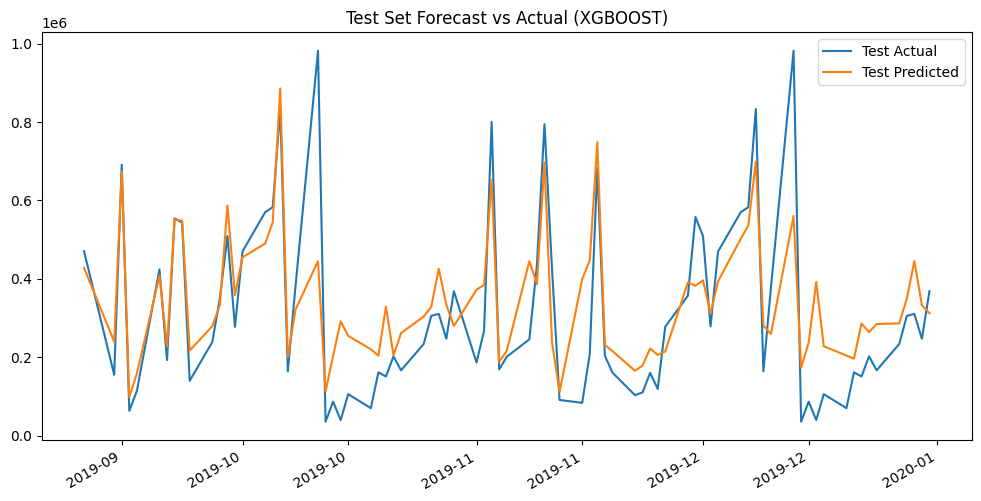

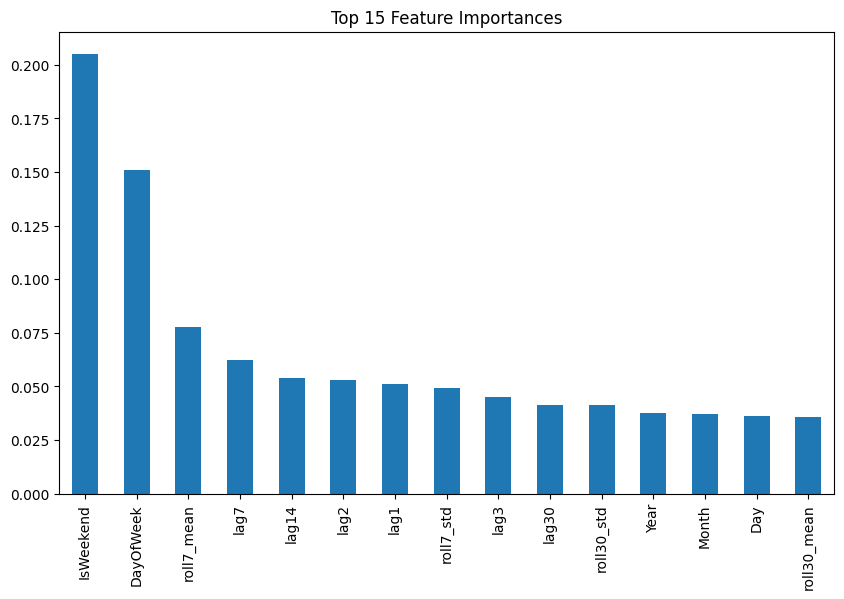

In [4]:
# ===============================
# 📌 Step 9: Final Evaluation (Test Only)
# ===============================
y_test_pred_best  = best_xgb.predict(X_test)
print("\n=== Final Results (Test) ===")
test_results = evaluate(y_test, y_test_pred_best, "Final-Test").to_frame()

# ===============================
# 📌 Step 10: Visualization
# ===============================
# Test Prediction vs Actual
plt.figure(figsize=(12,6))
plt.plot(daily_sales["Invoice Date"].iloc[val_size:], y_test, label="Test Actual")
plt.plot(daily_sales["Invoice Date"].iloc[val_size:], y_test_pred_best, label="Test Predicted")
plt.legend()
plt.title("Test Set Forecast vs Actual (XGBOOST)")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.show()

# Feature Importance
plt.figure(figsize=(10,6))
importances = best_xgb.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_importance.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances")
plt.show()


Next 7 Days Forecast (Best XGBoost):
        Date  Predicted Sales Amount
0 2020-01-01             311899.1875
1 2020-01-02             268784.3125
2 2020-01-03             422165.3750
3 2020-01-04             677435.5625
4 2020-01-05             382252.6875
5 2020-01-06             685164.4375
6 2020-01-07             339517.5625


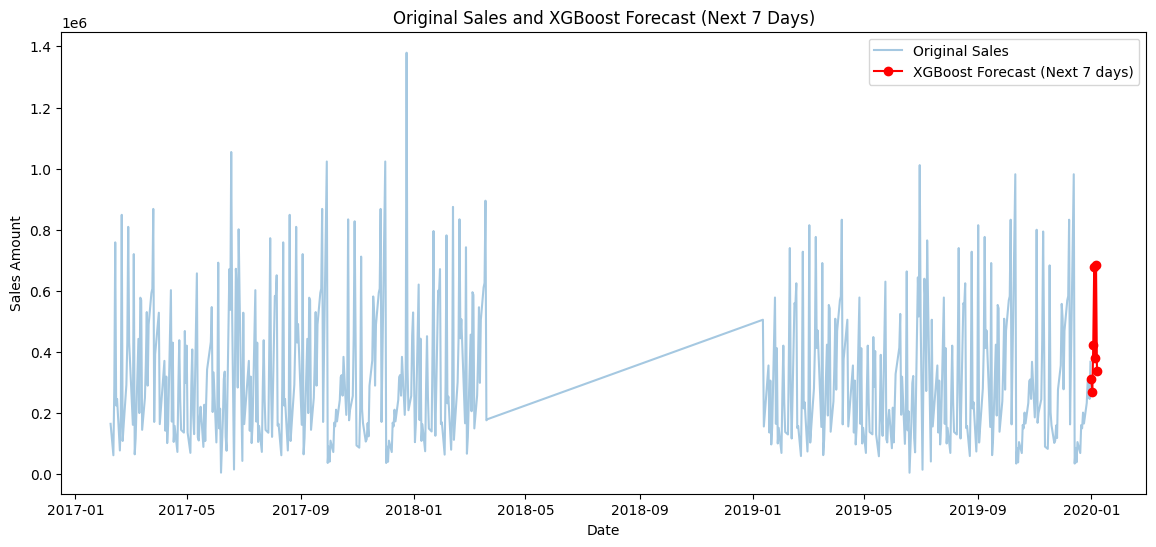

In [5]:
# ===============================
# 📌 Forecast Next 7 Days (Safe Version, Avoid IndexError)
# ===============================

last_row = X.iloc[-1:].copy()   # Take the last available row (latest features)
future_preds = []
future_dates = pd.date_range(start=daily_sales["Invoice Date"].iloc[-1] + pd.Timedelta(days=1), periods=7)

for i, date in enumerate(future_dates):
    # Predict the next day
    next_pred = best_xgb.predict(last_row)[0]
    future_preds.append(next_pred)

    # ---- Update lag features ----
    # lag1: yesterday
    last_row["lag1"] = next_pred

    # lag2: two days ago (if not enough predictions, use real history)
    if i < 1:
        last_row["lag2"] = y.iloc[-1]
    else:
        last_row["lag2"] = future_preds[-2]

    # lag3: three days ago
    if i < 2:
        last_row["lag3"] = y.iloc[-2]
    else:
        last_row["lag3"] = future_preds[-3]

    # lag7: seven days ago
    if i < 6:
        last_row["lag7"] = y.iloc[-7+i]  # Use real historical values if not enough predictions
    else:
        last_row["lag7"] = future_preds[-7]

    # lag14: fourteen days ago
    if i < 13:
        last_row["lag14"] = y.iloc[-14+i]
    else:
        last_row["lag14"] = future_preds[-14]

    # lag30: thirty days ago
    if i < 29:
        last_row["lag30"] = y.iloc[-30+i]
    else:
        last_row["lag30"] = future_preds[-30]

    # ---- Update rolling features ----
    history_vals = np.concatenate([y.values[-30:], future_preds])
    last_row["roll7_mean"] = np.mean(history_vals[-7:])
    last_row["roll30_mean"] = np.mean(history_vals[-30:])
    last_row["roll7_std"] = np.std(history_vals[-7:])
    last_row["roll30_std"] = np.std(history_vals[-30:])

    # ---- Update calendar features ----
    last_row["Day"] = date.day
    last_row["Month"] = date.month
    last_row["Year"] = date.year
    last_row["DayOfWeek"] = date.dayofweek
    last_row["IsWeekend"] = int(date.dayofweek >= 5)
    last_row["IsMonthStart"] = int(date.is_month_start)
    last_row["IsMonthEnd"] = int(date.is_month_end)

# Build forecast DataFrame
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Sales Amount": future_preds})
print("\nNext 7 Days Forecast (Best XGBoost):")
print(forecast_df)

# Visualization
plt.figure(figsize=(14,6))
plt.plot(daily_sales["Invoice Date"], daily_sales["Sales Amount"], label="Original Sales", alpha=0.4)
plt.plot(forecast_df["Date"], forecast_df["Predicted Sales Amount"], marker="o", label="XGBoost Forecast (Next 7 days)", color="red")
plt.title("Original Sales and XGBoost Forecast (Next 7 Days)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()


In [6]:
# ===============================
# 📌 Step 11: Save Best Model
# ===============================
print("\nSaving best model to disk...")
joblib.dump(best_xgb, "best_xgb_model.pkl")


Saving best model to disk...


['best_xgb_model.pkl']